In [1]:
import json
from pprint import pprint
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
import matplotlib
matplotlib.style.use('ggplot')
#ols models
import statsmodels.formula.api as sm
from patsy import dmatrices
import re
import scipy as sp
from tools import print_columns
import csv
import json

In [2]:
#Initialization of distributions


In [3]:
#read data
df_full = pd.read_csv("../../Data/recs2009_public.csv", low_memory=False)

In [4]:
df_full.shape

(12083, 931)

In [5]:
df_full['KOWNRENT'].value_counts()

1    8140
2    3801
3     142
Name: KOWNRENT, dtype: int64

In [6]:
index = df_full[(df_full['KOWNRENT'] ==1)].index

In [7]:
index

Int64Index([    0,     3,     4,     5,     6,     7,     8,     9,    11,
               15,
            ...
            12071, 12072, 12073, 12074, 12075, 12077, 12078, 12080, 12081,
            12082],
           dtype='int64', length=8140)

In [8]:
df = df_full.iloc[index][['MONEYPY', 'TOTSQFT', 'KWH', 'DOLLAREL', 'ONSITE', \
                          'ONSITEGRID', 'USESOLAR', 'TREESHAD', \
                         'YEARMADERANGE', 'ROOFTYPE']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a9711d0>]], dtype=object)

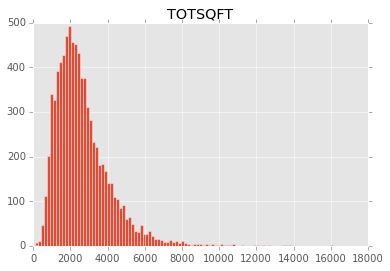

In [9]:
pd.DataFrame.hist(df_full.iloc[index], column='TOTSQFT', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a2abe10>]], dtype=object)

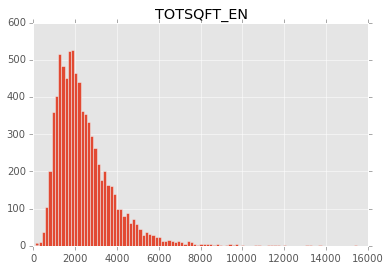

In [10]:
pd.DataFrame.hist(df_full.iloc[index], column='TOTSQFT_EN', bins = 100)

In [11]:
bins_TOTSQFT = pd.cut(df_full.iloc[index]['TOTSQFT'], bins = 24, labels = False, retbins=True)

In [12]:
bins_TOTSQFT[0].value_counts()

2     1882
3     1758
1     1367
4     1110
5      717
6      448
7      269
0      209
8      140
9       96
10      47
11      38
12      17
13      11
14      10
15       9
16       4
20       3
17       2
18       2
23       1
Name: TOTSQFT, dtype: int64

In [13]:
bins_TOTSQFT[1]

array([   103.998,    786.75 ,   1453.5  ,   2120.25 ,   2787.   ,
         3453.75 ,   4120.5  ,   4787.25 ,   5454.   ,   6120.75 ,
         6787.5  ,   7454.25 ,   8121.   ,   8787.75 ,   9454.5  ,
        10121.25 ,  10788.   ,  11454.75 ,  12121.5  ,  12788.25 ,
        13455.   ,  14121.75 ,  14788.5  ,  15455.25 ,  16122.   ])

In [14]:
df['TOTSQFT_C'] = pd.cut(df_full.iloc[index]['TOTSQFT'], bins = 24, labels = False, retbins=True)[0]

In [15]:
df['TOTSQFT_C'].value_counts() 

2     1882
3     1758
1     1367
4     1110
5      717
6      448
7      269
0      209
8      140
9       96
10      47
11      38
12      17
13      11
14      10
15       9
16       4
20       3
17       2
18       2
23       1
Name: TOTSQFT_C, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109ec6e80>]], dtype=object)

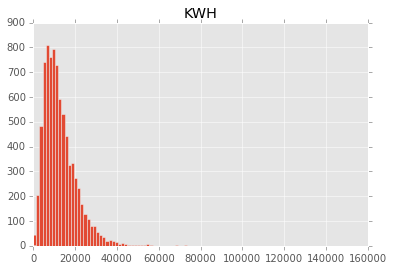

In [10]:
pd.DataFrame.hist(df_full.iloc[index], column='KWH', bins = 100)

In [17]:
count_KWH ,division_KWH = np.histogram(df_full.iloc[index]['KWH'],bins = 24)

In [18]:
bins_index_KWH = [x for x in range(13)]
bins_index_KWH.append(24)

In [19]:
bins_index_KWH

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24]

In [20]:
division_KWH[bins_index_KWH]

array([  1.70000000e+01,   6.27687500e+03,   1.25367500e+04,
         1.87966250e+04,   2.50565000e+04,   3.13163750e+04,
         3.75762500e+04,   4.38361250e+04,   5.00960000e+04,
         5.63558750e+04,   6.26157500e+04,   6.88756250e+04,
         7.51355000e+04,   1.50254000e+05])

In [21]:
df['KWH_C'] = pd.cut(df_full.iloc[index]['KWH'], bins = division_KWH[bins_index_KWH], labels = False, retbins=True)[0]

In [22]:
df['KWH_C'].value_counts()

1     3171
2     1860
0     1605
3      930
4      342
5      135
6       53
8       16
7       16
11       3
10       3
9        3
12       2
Name: KWH_C, dtype: int64

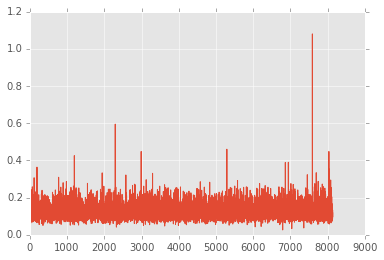

In [23]:
plt.plot(df['DOLLAREL']/df['KWH'])

In [24]:
np.mean(df['DOLLAREL']/df['KWH'])
np.std(df['DOLLAREL']/df['KWH'])

0.039906296777122909

In [26]:
#create json with parameters of a distribution 
#create list with bins ends and add inf right end
bins_TOTSQFT_params = bins_TOTSQFT[1][:-1].tolist()
bins_TOTSQFT_params.append(np.inf)

bins_KWH_params = division_KWH[bins_index_KWH][:-2].tolist()
bins_KWH_params.append(np.inf)

params = []

#house size
params.append({'name':'house_size','type':'continuous','N_BINS':bins_TOTSQFT[1].shape[0] - 1,\
                      'BIN_ENDS':bins_TOTSQFT_params, 'representation':'binned'})
params[-1]['values'] = list(range(0,params[-1]['N_BINS']))


#house age
params.append({'name':'house_age', 'type':'continuous', \
               'BIN_ENDS':[0, 5, 10, 20, 30, 40, 50, 60, np.inf],\
                      'representation':'binned',\
                      'values':[8, 7, 6, 5, 4, 3, 2, 1]})
params[-1]['N_BINS'] = len(params[-1]['values'])


#rooftype
params.append({'name':'roof_type', 'type':'discrete',\
                     'representation':'discrete'})
params[-1]['values'] = list(range(1, 9))
params[-1]['values'].append(-2)
params[-1]['N_BINS'] = len(params[-1]['values'])


#tree shade
params.append({'name':'tree_shade', 'type':'discrete', \
              'values':[0, 1], 'representation':'discrete'})
params[-1]['N_BINS'] = len(params[-1]['values'])


#gross household income
params.append({'name':'income', 'type':'continuous', 'representation':'binned', \
               'BIN_ENDS':[0, 2499, 4999, 7499, 9999, 14999, 19999, 24999, 29999, 34999, 39999, \
                          44999, 49999, 54999, 59999, 64999, 69999, 74999, 79999, 84999, 89999, \
                          94999, 99999, 119999, np.inf]})

params[-1]['N_BINS'] = len(params[-1]['BIN_ENDS']) - 1
params[-1]['values'] = list(range(1,params[-1]['N_BINS'] + 1))


#total electricity usage
params.append({'name':'electricity', 'type':'continuous', 'representation':'binned', \
              'BIN_ENDS':bins_KWH_params, 'N_BINS':len(bins_KWH_params) - 1})
params[-1]['values'] = list(range(0,params[-1]['N_BINS']))

In [27]:
with open('distribution.json', 'w') as outfile:
    json.dump(params, outfile)

In [ ]:
df_save = df[['TOTSQFT_C', 'YEARMADERANGE', 'ROOFTYPE', 'TREESHAD', 'MONEYPY', 'KWH_C']]

In [ ]:
#sort dataframe
df_save = df_save.sort_values(by=['TOTSQFT_C', 'YEARMADERANGE', 'ROOFTYPE', \
                                  'TREESHAD', 'MONEYPY', 'KWH_C'])

In [ ]:
df_save.to_csv('joint_distribution.csv')

In [ ]:
#smaller region

In [ ]:
index_region = df_full[(df_full['KOWNRENT'] ==1) & (df_full['DIVISION'] == 10)].index

In [ ]:
index_region.shape

In [ ]:
pd.DataFrame.hist(df_full.iloc[index_region], column='TOTSQFT', bins = 100)

In [ ]:
41472*24

In [ ]:
df_save['MONEYPY'].hist()

In [ ]:
df_save['MONEYPY'].value_counts()

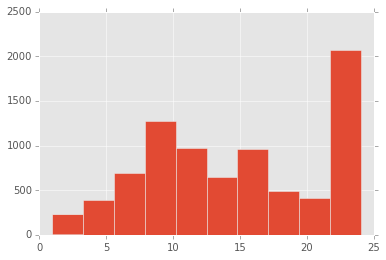

In [24]:
df['MONEYPY'].hist()

0.075